In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots appear in the notebook
%matplotlib inline

# Load the dataset from the data/ folder
data_path = "../data/resume_data.csv" 
df = pd.read_csv(data_path)

# Inspect the first few rows
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [22]:
# Check the shape of the dataset
print("Dataset shape:", df.shape)
print("")

# Show column names and data types
df.info()
print("")

# Check basic descriptive stats (numerical columns only)
df.describe()
print("")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

#Number of unique values in each category column
print("Unique values per column:")
print(df['Category'].nunique())
print(df['Category'].unique())

Dataset shape: (2484, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                2484 non-null   int64 
 1   Resume_str        2484 non-null   object
 2   Resume_html       2484 non-null   object
 3   Category          2484 non-null   object
 4   resume_length     2484 non-null   int64 
 5   processed_resume  2484 non-null   object
dtypes: int64(2), object(4)
memory usage: 116.6+ KB


Missing values per column:
ID                  0
Resume_str          0
Resume_html         0
Category            0
resume_length       0
processed_resume    0
dtype: int64
Unique values per column:
24
['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUC

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


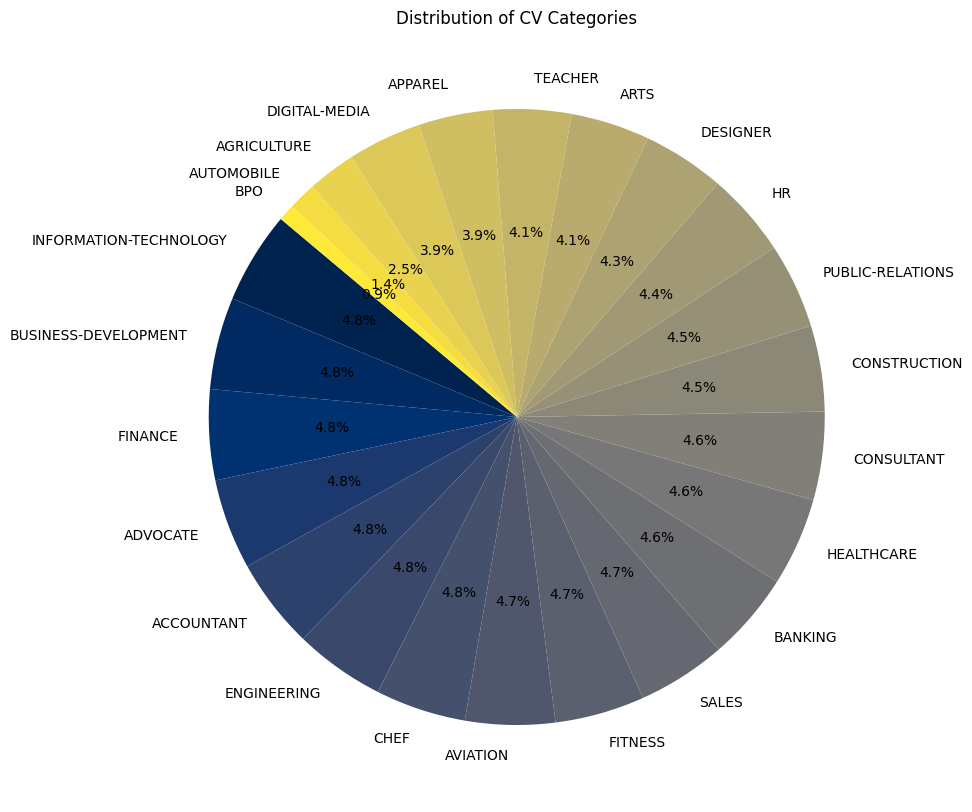

In [13]:
# Count how many resumes per category
category_counts = df["Category"].value_counts()
print(category_counts)

# Quick pie chart of category distribution with percentages
plt.figure(figsize=(10, 10))
category_counts.plot.pie(autopct='%1.1f%%', startangle=140, cmap='cividis', legend=False)
plt.title("Distribution of CV Categories")
plt.ylabel("")  # Remove the y-label
plt.show()


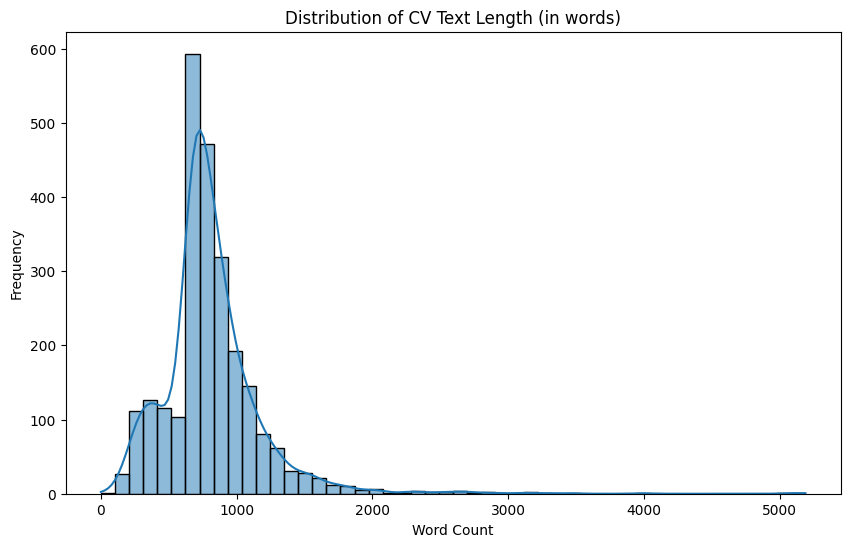

count    2484.000000
mean      811.325282
std       371.007491
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: resume_length, dtype: float64

In [5]:
# Calculate the length of each CV in terms of word count
df["resume_length"] = df["Resume_str"].apply(lambda x: len(str(x).split()))

# Plot the distribution of CV text lengths
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="resume_length", bins=50, kde=True)
plt.title("Distribution of CV Text Length (in words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Display descriptive statistics about the CV lengths
df["resume_length"].describe()

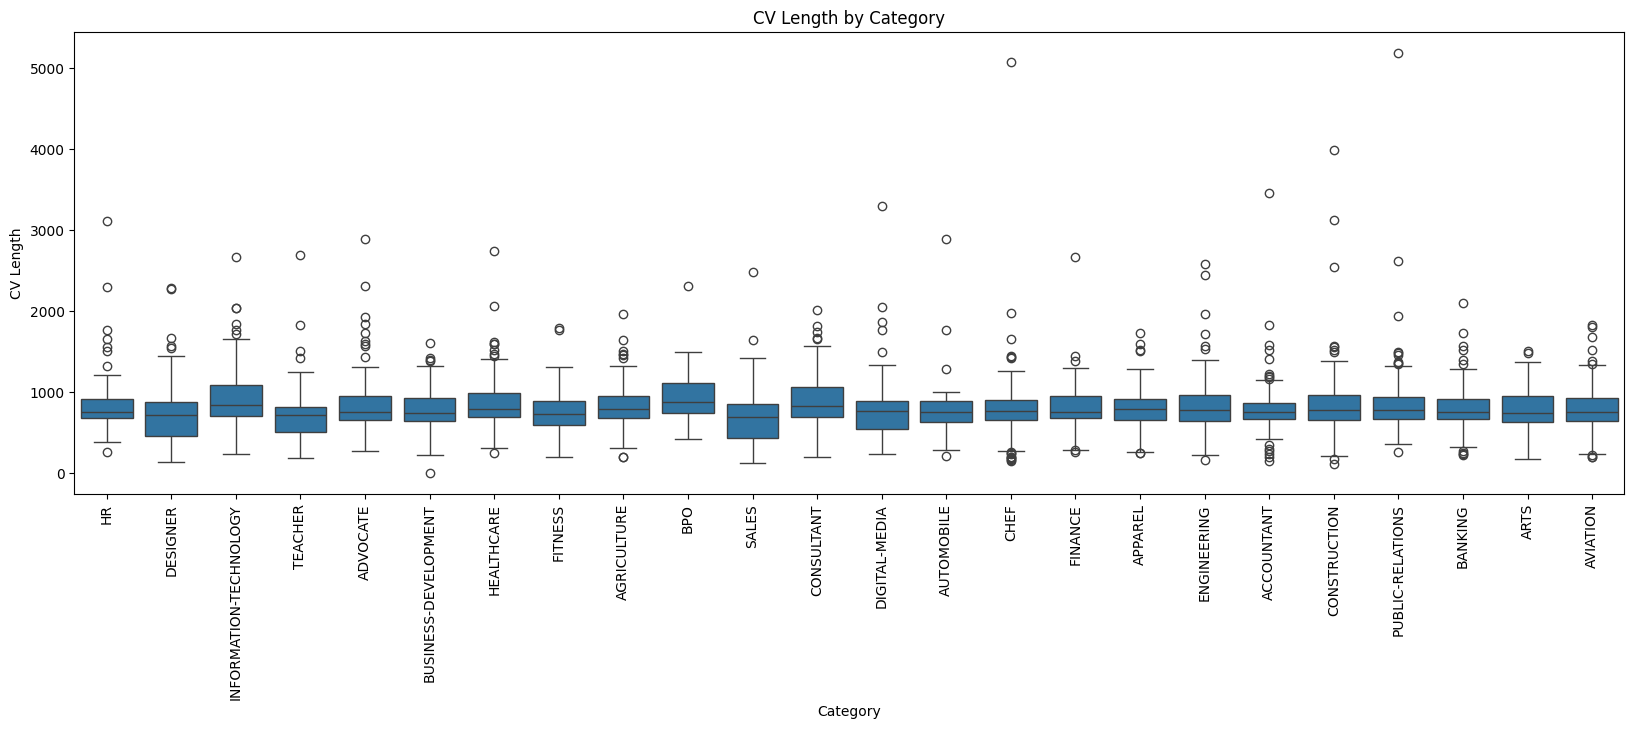

In [6]:
# Plot a boxplot to show the distribution of CV lengths by category
plt.figure(figsize=(20, 6))
sns.boxplot(x='Category', y='resume_length', data=df)
plt.xlabel('Category')
plt.ylabel('CV Length')
plt.title('CV Length by Category')
plt.xticks(rotation=90)
plt.show()


Generating initial word cloud to look at most common words.

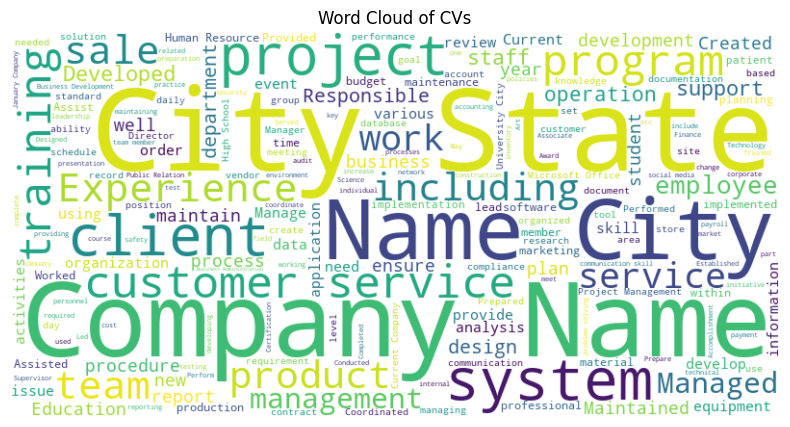

In [7]:
# Import the WordCloud module
from wordcloud import WordCloud

# Combine all cv texts into a single string
text = ' '.join(df['Resume_str'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of CVs')
plt.show()

Removing stop words discovered in initial word cloud.

In [111]:
import spacy

# Download the larger spaCy model
!python -m spacy download en_core_web_md

# Load the larger spaCy model
nlp = spacy.load("en_core_web_md")

# Add custom stop words (Discovered from the word cloud)
custom_stop_words = {"city", "state", "name", "company", "summary", "include"}
for word in custom_stop_words:
    nlp.Defaults.stop_words.add(word)
    nlp.vocab[word].is_stop = True

# Custom tokenizer to handle specific cases
def custom_tokenizer(nlp):
    prefix_re = spacy.util.compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = spacy.util.compile_suffix_regex(nlp.Defaults.suffixes)
    infix_re = spacy.util.compile_infix_regex(nlp.Defaults.infixes)
    return spacy.tokenizer.Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                     suffix_search=suffix_re.search,
                                     infix_finditer=infix_re.finditer,
                                     token_match=None)

nlp.tokenizer = custom_tokenizer(nlp)

# Tokenize + lemmatize text with advanced techniques
def preprocess_text(text):
    """
    Convert to doc, remove punctuation & stop words, lemmatize tokens, and filter by POS tags.
    """
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and len(token.text.strip()) > 2 and token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV'}]
    return " ".join(tokens)

# Apply the preprocess_text function to the entire dataframe
df["processed_resume"] = df["Resume_str"].apply(preprocess_text)

# Display the first few rows of the dataframe to verify the changes
df[["Resume_str", "processed_resume"]].head()


,Resume_str,processed_resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,administrator marketing associate administrato...
1,"HR SPECIALIST, US HR OPERATIONS ...",specialist operation versatile medium professi...
2,HR DIRECTOR Summary Over 2...,director year experience recruit year human re...
3,HR SPECIALIST Summary Dedica...,specialist dedicated drive dynamic year custom...
4,HR MANAGER Skill Highlights ...,manager skill highlight skill startup new orga...


Another word cloud after removing stop words.

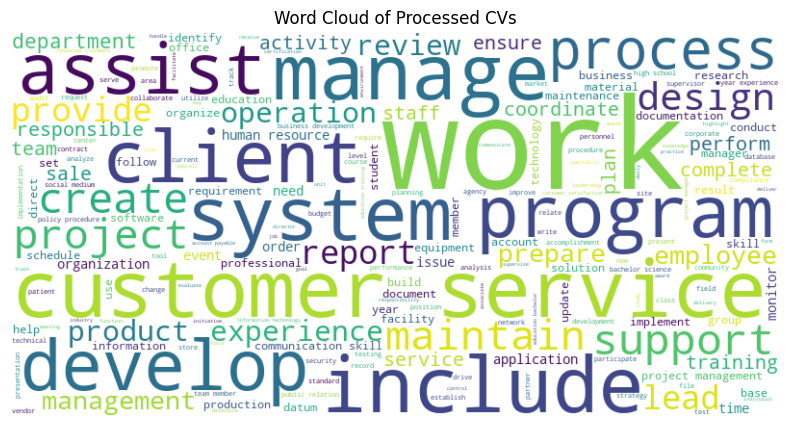

In [112]:
# Combine all processed resume texts into a single string
processed_text = ' '.join(df['processed_resume'])

# Generate a word cloud image from the processed text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Processed CVs')
plt.show()


# Category-wise Word Frequency

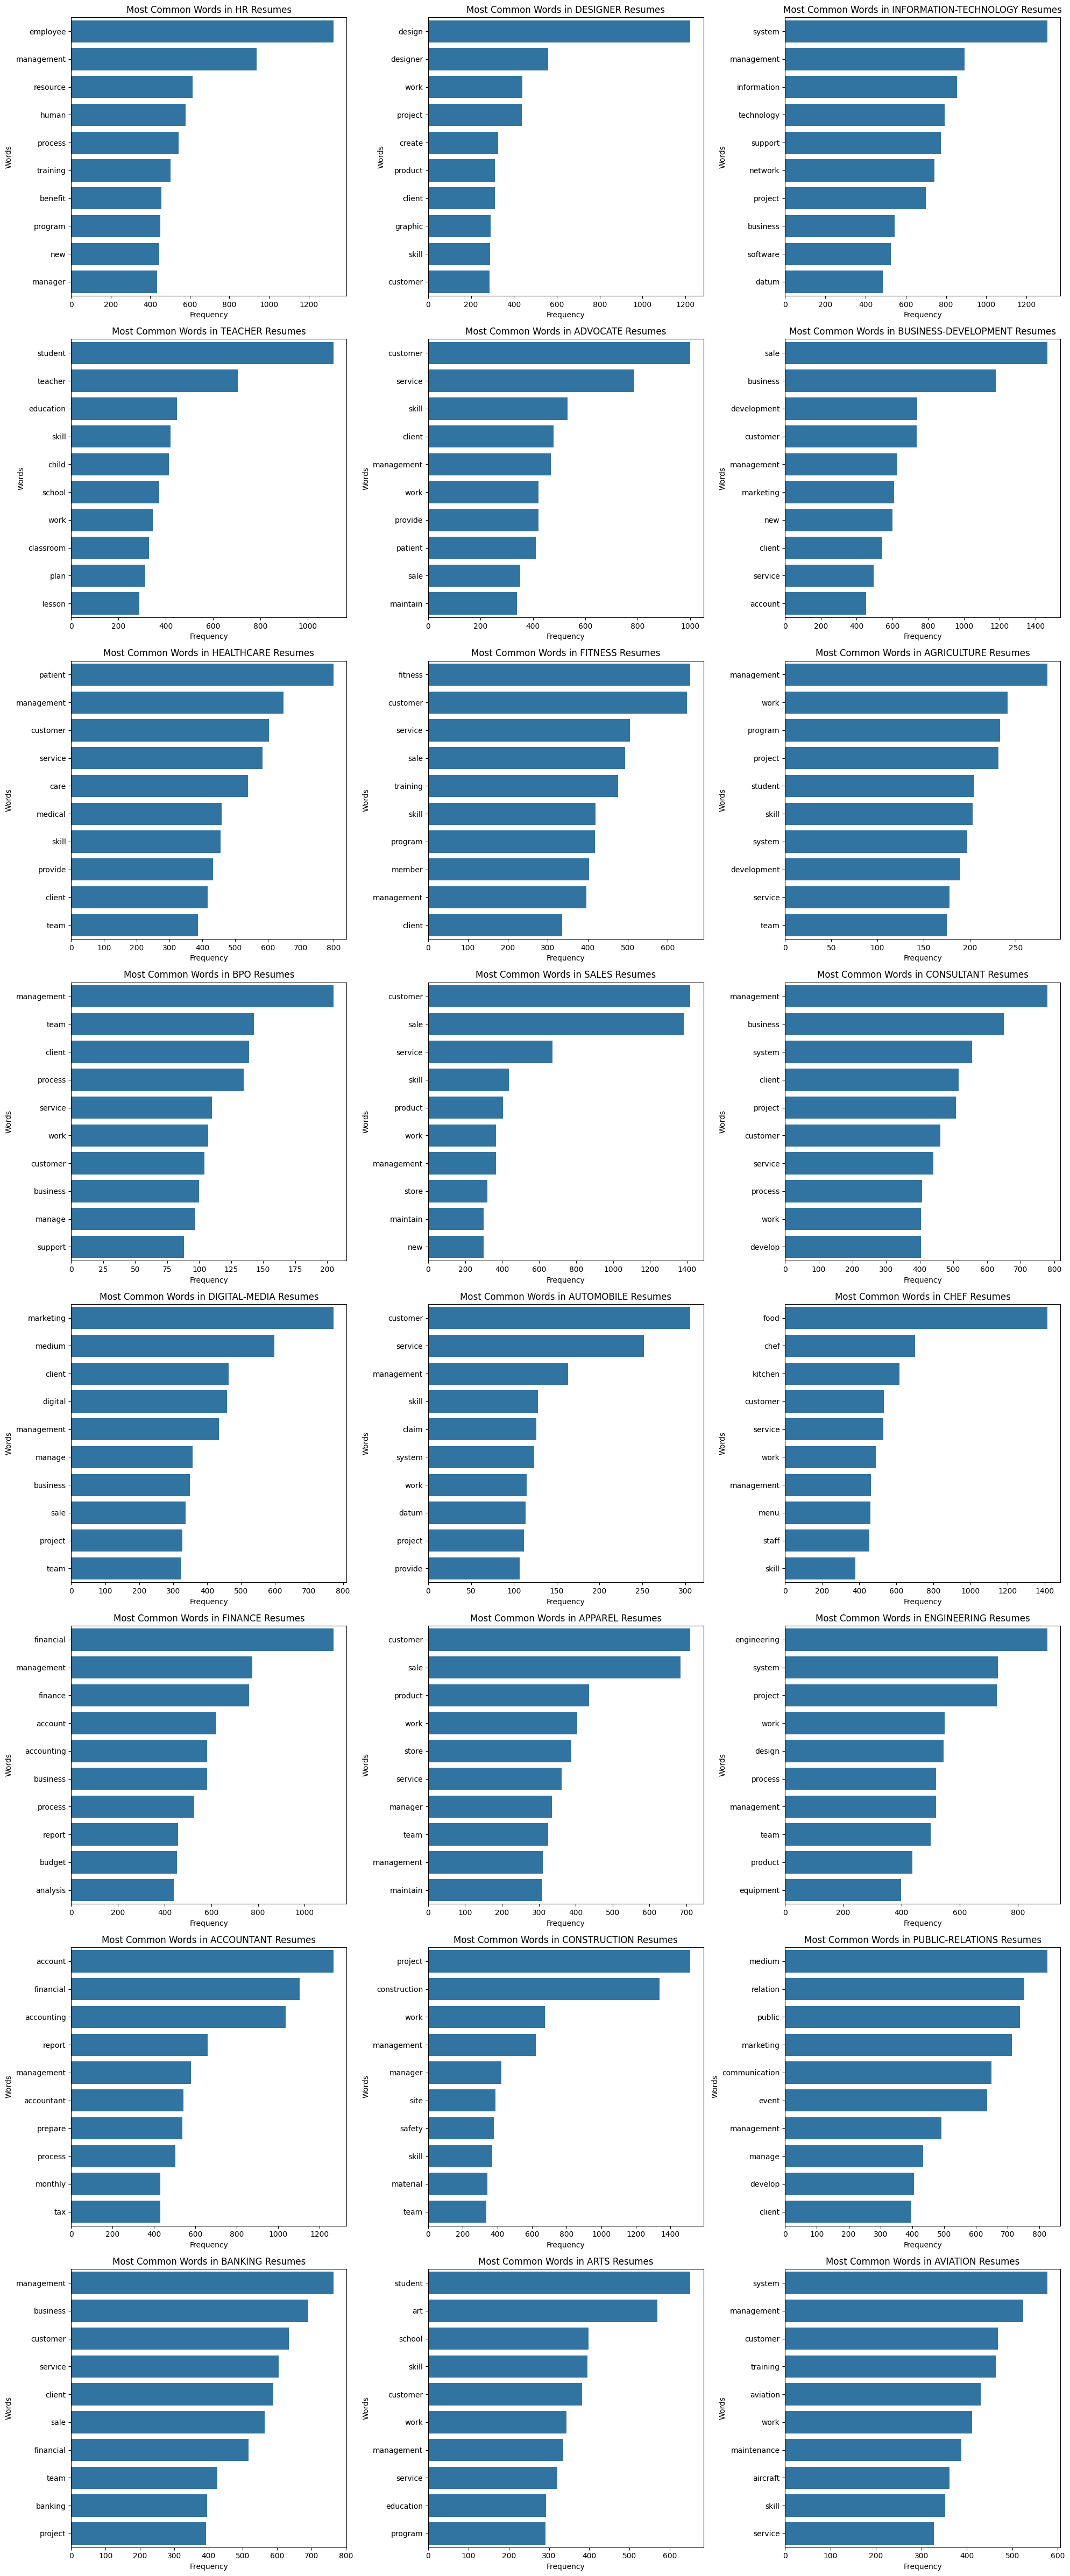

In [113]:
from collections import Counter

# Count the frequency of each word for each category
category_word_counts = {}
for category in df['Category'].unique():
    category_text = ' '.join(df[df['Category'] == category]['processed_resume'])
    tokens = category_text.split()
    category_word_counts[category] = Counter(tokens)

# Plot the most common words for each category using a grid of bar plots
num_categories = len(category_word_counts)
num_cols = 3
num_rows = (num_categories + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 6))
axes = axes.flatten()

for i, (category, word_count) in enumerate(category_word_counts.items()):
    common_words = word_count.most_common(10)
    words, counts = zip(*common_words)
    
    sns.barplot(x=list(counts), y=list(words), ax=axes[i])
    axes[i].set_title(f"Most Common Words in {category} Resumes")
    axes[i].set_xlabel("Frequency")
    axes[i].set_ylabel("Words")

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [114]:
from gensim.models import Word2Vec

# Tokenize each processed resume into a list of words
tokenized_resumes = df['processed_resume'].apply(lambda x: x.split()).tolist()

# Train a Word2Vec model on the tokenized resumes
w2v_model = Word2Vec(
    sentences=tokenized_resumes, 
    vector_size=100,   # You can adjust the vector size as needed
    window=5, 
    min_count=2, 
    workers=4, 
    seed=42
)

# Function to calculate the average word vector for a document
def document_vector(tokens):
    valid_words = [word for word in tokens if word in w2v_model.wv.key_to_index]
    if valid_words:
        return np.mean(w2v_model.wv[valid_words], axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

# Create document vectors for all resumes
features = np.array([document_vector(tokens) for tokens in tokenized_resumes])

# Overwrite tfidf_matrix with the new Word2Vec feature matrix to be used in subsequent cells
tfidf_matrix = features

print("Word2Vec feature matrix shape:", tfidf_matrix.shape)


Word2Vec feature matrix shape: (2484, 100)


In [115]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Category' column
df['Category_encoded'] = label_encoder.fit_transform(df['Category'])

# Display the first few rows to verify the changes
df[['Category', 'Category_encoded']].head()

,Category,Category_encoded
0,HR,19
1,HR,19
2,HR,19
3,HR,19
4,HR,19


In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix, 
    df['Category_encoded'], 
    test_size=0.2, 
    random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1987, 100)
Test set shape: (497, 100)


In [117]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_pred = baseline_model.predict(X_test)

# Compute and print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", acc)

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate and print the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

Test Set Accuracy: 0.03822937625754527

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        21
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        27
          10       0.00      0.00      0.00        24
          11       0.00      0.00      0.00        34
          12       0.00      0.00      0.00        20
          13       0.00      0.00      0.00        19
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        21
          16      

c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [118]:
from sklearn.neighbors import KNeighborsClassifier

# Using 'distance' weighting to give closer points more influence
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [119]:
# Predict on the test set using the KNN model
y_pred_knn = knn.predict(X_test)

# Compute and print the accuracy score
acc_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Model Test Set Accuracy:", acc_knn)

# Generate and print the classification report
print("\nKNN Model Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Generate and print the confusion matrix
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)
print("\nKNN Model Confusion Matrix:")
print(conf_mat_knn)

KNN Model Test Set Accuracy: 0.4225352112676056

KNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.79      0.65        29
           1       0.26      0.40      0.32        30
           2       0.06      0.12      0.08         8
           3       0.23      0.30      0.26        20
           4       0.18      0.17      0.17        18
           5       0.00      0.00      0.00         6
           6       0.33      0.48      0.39        21
           7       0.48      0.48      0.48        23
           8       0.00      0.00      0.00         2
           9       0.47      0.33      0.39        27
          10       0.75      0.62      0.68        24
          11       0.87      0.59      0.70        34
          12       0.19      0.15      0.17        20
          13       0.50      0.47      0.49        19
          14       0.47      0.36      0.41        25
          15       0.52      0.52      0.52        21

In [120]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for KNN
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best KNN estimator to predict on the test set
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
print("Test set accuracy of best KNN model:", acc_best)

Best parameters: {'n_neighbors': 18, 'weights': 'distance'}
Best cross-validation score: 0.47359340784527165
Test set accuracy of best KNN model: 0.47283702213279677


In [121]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation with the best KNN classifier
cv_scores_best_knn = cross_val_score(best_knn, tfidf_matrix, df['Category_encoded'], cv=5, scoring='accuracy')

print("Cross-validation scores with best KNN:", cv_scores_best_knn)
print("Mean cross-validation accuracy with best KNN:", cv_scores_best_knn.mean())

Cross-validation scores with best KNN: [0.4889336  0.52112676 0.48289738 0.45875252 0.43951613]
Mean cross-validation accuracy with best KNN: 0.4782452781203349


In [122]:
from sklearn.svm import SVC

# Initialize the SVM model with balanced class weights
svm_model = SVC(kernel='linear', C=1, random_state=42, class_weight='balanced')

# Train the SVM model
svm_model.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', kernel='linear', random_state=42)

In [123]:
# Evaluate the SVM model on the test set
y_pred_svm = svm_model.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Model Test Set Accuracy:", acc_svm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

SVM Model Test Set Accuracy: 0.5251509054325956

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.77        29
           1       0.38      0.33      0.36        30
           2       0.08      0.12      0.10         8
           3       0.32      0.30      0.31        20
           4       0.05      0.06      0.05        18
           5       0.07      0.17      0.10         6
           6       0.45      0.67      0.54        21
           7       0.71      0.52      0.60        23
           8       0.14      0.50      0.22         2
           9       0.68      0.48      0.57        27
          10       0.89      0.67      0.76        24
          11       0.81      0.65      0.72        34
          12       0.33      0.25      0.29        20
          13       0.68      0.68      0.68        19
          14       0.68      0.60      0.64        25
          15       0.55      0.57      0.56        21
         

In [124]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

print("Best parameters for SVM:", grid_search_svm.best_params_)
print("Best cross-validation score for SVM:", grid_search_svm.best_score_)

# Use the best SVM estimator to predict on the test set
best_svm = grid_search_svm.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)
acc_best_svm = accuracy_score(y_test, y_pred_best_svm)
print("Test set accuracy of best SVM model:", acc_best_svm)

Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score for SVM: 0.5158715491816767
Test set accuracy of best SVM model: 0.5150905432595574


In [125]:
# Perform 5-fold cross-validation using the best SVM model from grid search
cv_scores_best_svm = cross_val_score(best_svm, tfidf_matrix, df['Category_encoded'], cv=5, scoring='accuracy')
print("Best SVM Cross-validation scores:", cv_scores_best_svm)
print("Mean Best SVM CV accuracy:", cv_scores_best_svm.mean())

Best SVM Cross-validation scores: [0.54527163 0.53923541 0.50905433 0.48490946 0.47177419]
Mean Best SVM CV accuracy: 0.510049003699617


In [126]:
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights based on y_train
class_weights = dict(zip(np.unique(y_train), compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)))
# Create sample weights for each training instance
sample_weights = y_train.map(class_weights)

# Initialize and train the Naive Bayes model with sample weights
nb_model = GaussianNB()
nb_model.fit(X_train, y_train, sample_weight=sample_weights)

GaussianNB()

In [127]:
# Evaluate the Naive Bayes model on the test set
y_pred_nb = nb_model.predict(X_test)

acc_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Model Test Set Accuracy:", acc_nb)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

Naive Bayes Model Test Set Accuracy: 0.47283702213279677

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83        29
           1       0.36      0.30      0.33        30
           2       0.04      0.12      0.06         8
           3       0.50      0.15      0.23        20
           4       0.08      0.06      0.07        18
           5       0.00      0.00      0.00         6
           6       0.39      0.52      0.45        21
           7       0.58      0.30      0.40        23
           8       0.00      0.00      0.00         2
           9       0.55      0.59      0.57        27
          10       0.76      0.67      0.71        24
          11       0.93      0.38      0.54        34
          12       0.00      0.00      0.00        20
          13       0.69      0.58      0.63        19
          14       0.65      0.60      0.62        25
          15       0.45      0.62      0.52        21


In [ ]:
# Define the hyperparameter grid for the MultinomialNB model
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

# Initialize and run GridSearchCV with 5-fold cross-validation
#grid_search_nb = GridSearchCV(nb_model, param_grid_nb, cv=5, scoring='accuracy', n_jobs=-1)
#grid_search_nb.fit(X_train, y_train)

#print("Best parameters for Naive Bayes:", grid_search_nb.best_params_)
#print("Best cross-validation score for Naive Bayes:", grid_search_nb.best_score_)

# Evaluate the best Naive Bayes model on the test set
#best_nb = grid_search_nb.best_estimator_
#y_pred_best_nb = best_nb.predict(X_test)
#acc_best_nb = accuracy_score(y_test, y_pred_best_nb)
#print("Test set accuracy for best Naive Bayes model:", acc_best_nb)

ValueError: Invalid parameter 'alpha' for estimator GaussianNB(). Valid parameters are: ['priors', 'var_smoothing'].

In [ ]:
cv_scores_best_nb = cross_val_score(best_nb, tfidf_matrix, df['Category_encoded'], cv=5, scoring='accuracy')
print("Cross-validation scores for best Naive Bayes model:", cv_scores_best_nb)
print("Mean cross-validation score for best Naive Bayes model:", cv_scores_best_nb.mean())

Cross-validation scores for best Naive Bayes model: [0.62374245 0.57746479 0.57545272 0.56539235 0.50604839]
Mean cross-validation score for best Naive Bayes model: 0.5696201401960147


In [130]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the decision tree classifier with balanced class weights
decision_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [131]:
# Predict on the test set using the decision tree model
y_pred_tree = decision_tree.predict(X_test)

# Compute and print the accuracy score
acc_tree = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Model Test Set Accuracy:", acc_tree)

# Generate and print the classification report
print("\nDecision Tree Model Classification Report:")
print(classification_report(y_test, y_pred_tree))

# Generate and print the confusion matrix
conf_mat_tree = confusion_matrix(y_test, y_pred_tree)
print("\nDecision Tree Model Confusion Matrix:")
print(conf_mat_tree)

Decision Tree Model Test Set Accuracy: 0.2977867203219316

Decision Tree Model Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75        29
           1       0.17      0.13      0.15        30
           2       0.00      0.00      0.00         8
           3       0.12      0.15      0.14        20
           4       0.15      0.22      0.18        18
           5       0.12      0.33      0.17         6
           6       0.19      0.24      0.21        21
           7       0.22      0.17      0.20        23
           8       0.00      0.00      0.00         2
           9       0.27      0.15      0.19        27
          10       0.67      0.50      0.57        24
          11       0.56      0.29      0.38        34
          12       0.06      0.10      0.07        20
          13       0.39      0.47      0.43        19
          14       0.44      0.28      0.34        25
          15       0.19      0.24

In [132]:
# Define the hyperparameter grid for the Decision Tree model
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with 5-fold cross-validation using a new DecisionTreeClassifier
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              param_grid=param_grid_dt,
                              cv=5,
                              scoring='accuracy',
                              n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

print("Best parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best cross-validation score for Decision Tree:", grid_search_dt.best_score_)

# Use the best Decision Tree model to predict on the test set
best_dt = grid_search_dt.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)
acc_best_dt = accuracy_score(y_test, y_pred_best_dt)
print("Test set accuracy of best Decision Tree model:", acc_best_dt)

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}
Best cross-validation score for Decision Tree: 0.33319114464007693
Test set accuracy of best Decision Tree model: 0.31388329979879276


In [133]:
cv_scores_best_dt = cross_val_score(best_dt, tfidf_matrix, df['Category_encoded'], cv=5, scoring='accuracy')
print("Decision Tree best model cross-validation scores:", cv_scores_best_dt)
print("Mean cross-validation accuracy:", cv_scores_best_dt.mean())

Decision Tree best model cross-validation scores: [0.35814889 0.31790744 0.3138833  0.30784708 0.30241935]
Mean cross-validation accuracy: 0.3200412150321283


In [134]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [135]:
# Evaluate Logistic Regression model
y_pred_log = logistic_model.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Model Test Set Accuracy:", acc_log)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

Logistic Regression Model Test Set Accuracy: 0.5372233400402414

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        29
           1       0.46      0.43      0.45        30
           2       0.09      0.12      0.11         8
           3       0.40      0.30      0.34        20
           4       0.17      0.11      0.13        18
           5       0.00      0.00      0.00         6
           6       0.45      0.67      0.54        21
           7       0.72      0.57      0.63        23
           8       0.00      0.00      0.00         2
           9       0.79      0.56      0.65        27
          10       0.76      0.67      0.71        24
          11       0.80      0.59      0.68        34
          12       0.28      0.25      0.26        20
          13       0.64      0.74      0.68        19
          14       0.74      0.56      0.64        25
          15       0.48      0.57      0.52    

c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [136]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for Logistic Regression
param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search_log = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                               param_grid_log, 
                               cv=5, 
                               scoring='accuracy', 
                               n_jobs=-1)
grid_search_log.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search_log.best_params_)
print("Best cross-validation score for Logistic Regression:", grid_search_log.best_score_)

# Use the best Logistic Regression estimator to predict on the test set
best_log = grid_search_log.best_estimator_
y_pred_best_log = best_log.predict(X_test)
acc_best_log = accuracy_score(y_test, y_pred_best_log)
print("Test set accuracy of best Logistic Regression model:", acc_best_log)

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score for Logistic Regression: 0.54002253078997
Test set accuracy of best Logistic Regression model: 0.545271629778672


In [137]:
from sklearn.metrics import classification_report

# Define a dictionary to store the predictions of each model
model_predictions = {
    "Decision Tree": y_pred_best_dt,
    "Logistic Regression": y_pred_best_log,
    "Naive Bayes": y_pred_best_nb,
    "SVM": y_pred_best_svm,
    "KNN": y_pred_knn
}

# Iterate over the models and print the classification report for each
for model_name, y_pred in model_predictions.items():
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.66      0.66      0.66        29
           1       0.12      0.10      0.11        30
           2       0.00      0.00      0.00         8
           3       0.14      0.15      0.14        20
           4       0.17      0.28      0.21        18
           5       0.00      0.00      0.00         6
           6       0.25      0.33      0.29        21
           7       0.30      0.30      0.30        23
           8       0.00      0.00      0.00         2
           9       0.33      0.19      0.24        27
          10       0.60      0.62      0.61        24
          11       0.65      0.38      0.48        34
          12       0.17      0.25      0.20        20
          13       0.36      0.42      0.39        19
          14       0.33      0.20      0.25        25
          15       0.35      0.33      0.34        21
          16       0.33      0.42      

c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ItsLo\anaconda3\envs\cv-env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
